In [12]:
from src import csv_handlers, data_retrieval, string_handlers
import numpy as np
import pandas as pd
from nltk.text import TextCollection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns
from scipy import sparse
from datetime import datetime

In [ ]:
data_retrieval.download_bulk_in_batches("2000-01-01", "2020-01-01", "data_full", 
                                        award_types=["contracts", "direct_payments", "grants", 
                                                     "idvs", "loans", "other_financial_assistance"], batch_size=12)

In [ ]:
csv_handlers.extract_all_recipients("data_full")

In [2]:
df = csv_handlers.get_recipient_data_from_csv("data_full/all_recipients.csv")
df.shape

2020-02-05 21:13:17,988 - src.csv_handlers - DEBUG - Reading file: data_full/all_recipients.csv


(6194685, 24)

In [3]:
df.head()

,recipient_duns,recipient_name,recipient_doing_business_as_name,recipient_parent_duns,recipient_parent_name,recipient_country_code,recipient_country_name,recipient_address_line_1,recipient_address_line_2,recipient_city_name,...,recipient_phone_number,recipient_fax_number,recipient_city_code,recipient_county_code,recipient_county_name,recipient_zip_code,recipient_zip_last_4_code,recipient_foreign_city_name,recipient_foreign_province_name,recipient_foreign_postal_code
0,825313153,"BLUEWATER MANAGEMENT GROUP, LLC",NaN,825313153.0,BLUEWATER MANAGEMENT GROUP LLC,USA,UNITED STATES,9642 28TH BAY ST,NaN,NORFOLK,...,7573620489,7573620266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,534640179,MIRAAT AL RIYADH COMPANY,NaN,534640179.0,MIRAAT AL RIYADH COMPANY,SAU,SAUDI ARABIA,AISHAH BINT ABI BAKR,NaN,RIYADH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,58311945,HOWMEDICA OSTEONICS CORP.,NaN,5373089.0,STRYKER CORPORATION,USA,UNITED STATES,325 CORPORATE DR,NaN,MAHWAH,...,7577757224,2018316553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,691754543,"COCA-COLA EAST JAPAN CO., LTD.",NaN,691754543.0,COCA-COLA CENTRAL JAPAN CO. LTD.,JPN,JAPAN,"6-1-20, AKASAKA","KOKUSAI SHIN-AKASAKA WEST BUILDING,",MINATO-KU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,148983229,SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,NaN,78745061.0,SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,USA,UNITED STATES,155 PASSAIC AVE,NaN,FAIRFIELD,...,9738084701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.notnull().sum()

recipient_duns                      4659322
recipient_name                      6193360
recipient_doing_business_as_name     223131
recipient_parent_duns               3262856
recipient_parent_name               3190931
recipient_country_code              5400560
recipient_country_name              3817797
recipient_address_line_1            5407523
recipient_address_line_2             441468
recipient_city_name                 6061719
recipient_state_code                5991718
recipient_state_name                4598236
recipient_zip_4_code                2731517
recipient_congressional_district    5402585
recipient_phone_number              1453475
recipient_fax_number                1322066
recipient_city_code                 3073194
recipient_county_code               3331958
recipient_county_name               3320655
recipient_zip_code                  3208097
recipient_zip_last_4_code           2568760
recipient_foreign_city_name           17565
recipient_foreign_province_name 

In [5]:
len(df.recipient_name.unique())

2499466

In [6]:
companies = np.concatenate([df.recipient_name.dropna().unique(),df.recipient_parent_name.dropna().unique(),
                            df.recipient_doing_business_as_name.dropna().unique()])
companies = np.unique(companies)
companies_name_df = pd.DataFrame(companies, columns=['old'])
companies = string_handlers.fix_letters(pd.Series(companies))
companies = string_handlers.fix_words(companies)
companies_name_df['new'] = companies
companies = pd.Series(companies).unique()

In [7]:
df['clean_recipient_name'] = pd.merge(df.recipient_name, companies_name_df, right_on='old', 
                                      left_on = 'recipient_name', how='left')['new'].values
df['clean_recipient_parent_name'] = pd.merge(df.recipient_parent_name, companies_name_df, right_on='old', 
                                      left_on = 'recipient_parent_name', how='left')['new'].values
df['clean_recipient_doing_business_as_name'] = pd.merge(df.recipient_doing_business_as_name, companies_name_df, 
                                                        right_on='old', left_on = 'recipient_doing_business_as_name',
                                                        how='left')['new'].values

In [8]:
us_addr = pd.read_csv("us_addr.csv")
us_addr.fillna('', inplace=True)
df.fillna('', inplace=True)
df = df.merge(us_addr, how='left')
df.to_csv('processed_df.csv', index=False)

In [9]:
df = pd.read_csv('processed_df.csv', low_memory = False)

In [10]:
df.head()

,recipient_duns,recipient_name,recipient_doing_business_as_name,recipient_parent_duns,recipient_parent_name,recipient_country_code,recipient_country_name,recipient_address_line_1,recipient_address_line_2,recipient_city_name,...,recipient_zip_code,recipient_zip_last_4_code,recipient_foreign_city_name,recipient_foreign_province_name,recipient_foreign_postal_code,clean_recipient_name,clean_recipient_parent_name,clean_recipient_doing_business_as_name,recipient_state_fixed,recipient_address_line_fixed
0,825313153,"BLUEWATER MANAGEMENT GROUP, LLC",NaN,825313153.0,BLUEWATER MANAGEMENT GROUP LLC,USA,UNITED STATES,9642 28TH BAY ST,NaN,NORFOLK,...,NaN,NaN,NaN,NaN,NaN,BLUEWATER MGMT GRP LLC,BLUEWATER MGMT GRP LLC,NaN,VIRGINIA,9642 28TH BAY SAINT
1,534640179,MIRAAT AL RIYADH COMPANY,NaN,534640179.0,MIRAAT AL RIYADH COMPANY,SAU,SAUDI ARABIA,AISHAH BINT ABI BAKR,NaN,RIYADH,...,NaN,NaN,NaN,NaN,NaN,MIRAAT AL RIYADH CO,MIRAAT AL RIYADH CO,NaN,NaN,AISHAH BINT ABI BAKR
2,58311945,HOWMEDICA OSTEONICS CORP.,NaN,5373089.0,STRYKER CORPORATION,USA,UNITED STATES,325 CORPORATE DR,NaN,MAHWAH,...,NaN,NaN,NaN,NaN,NaN,HOWMEDICA OSTEONICS CORP,STRYKER CORP,NaN,NEW JERSEY,325 CORPORATE DOCTOR
3,691754543,"COCA-COLA EAST JAPAN CO., LTD.",NaN,691754543.0,COCA-COLA CENTRAL JAPAN CO. LTD.,JPN,JAPAN,"6-1-20, AKASAKA","KOKUSAI SHIN-AKASAKA WEST BUILDING,",MINATO-KU,...,NaN,NaN,NaN,NaN,NaN,COCA COLA EAST JAPAN CO LTD,COCA COLA CENTRAL JAPAN CO LTD,NaN,NaN,6-1-20 AKASAKA KOKUSAI SHIN-AKASAKA WEST BUILDING
4,148983229,SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,NaN,78745061.0,SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,USA,UNITED STATES,155 PASSAIC AVE,NaN,FAIRFIELD,...,NaN,NaN,NaN,NaN,NaN,SCIENCE APPLICATIONS INTL CORP,SCIENCE APPLICATIONS INTL CORP,NaN,NEW JERSEY,155 PASSAIC AVENUE


# Company Name to DF mapping

In [14]:
comp_df = pd.DataFrame(companies, columns=['company_name'])
comp_df = comp_df.reset_index()
comp_df = comp_df.set_index('company_name')
comp_df.columns = ['company_name_index']
comp_df

rec_indexes = comp_df.loc[df.clean_recipient_name.fillna('')].values.flatten()
par_indexes = comp_df.loc[df.clean_recipient_parent_name.fillna('')].values.flatten()
bus_indexes = comp_df.loc[df.clean_recipient_doing_business_as_name.fillna('')].values.flatten()

one_hot = sparse.lil_matrix((df.shape[0],comp_df.shape[0]))

one_hot[range(df.shape[0]),rec_indexes] = True
one_hot[range(df.shape[0]),par_indexes] = True
one_hot[range(df.shape[0]),bus_indexes] = True

one_hot_row = one_hot.T.tocsr()

# Chair DF

In [15]:
chair_df = pd.read_excel("company_dataset_identifier.xlsx")

In [16]:
chair_addr = pd.read_csv("chair_addr.csv")
chair_df = chair_df.merge(chair_addr, on="gvkey")

In [17]:
cleaned= string_handlers.fix_letters(chair_df.conm)
chair_df['cleaned']= string_handlers.fix_words(cleaned)
chair_df.head()

,gvkey,conm,conml,state,add1,add2,add3,add4,addzip,state_fixed,add_fixed,cleaned
0,1000,A & E PLASTIK PAK INC,A & E Plastik Pak Inc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A&E PLASTIK PAK INC
1,1001,A & M FOOD SERVICES INC,A & M Food Services Inc,OK,1924 South Utica Avenue,NaN,NaN,NaN,94104,OKLAHOMA,1924 SOUTH UTICA AVENUE,A&M FOOD SVCS INC
2,1002,AAI CORP,AAI Corp,MD,124 Industry Lane,NaN,NaN,NaN,21030-0126,MARYLAND,124 INDUSTRY LANE,AAI CORP
3,1003,A.A. IMPORTING CO INC,A.A. Importing Co Inc,MO,7700 Hall Street,NaN,NaN,NaN,63125,MISSOURI,7700 HALL STREET,AA IMPORTING CO INC
4,1004,AAR CORP,AAR Corp,IL,"One AAR Place, 1100 North Wood Dale Road",NaN,NaN,NaN,60191,ILLINOIS,1 AAR PLACE 1100 NORTH WOOD DALE ROAD,AAR CORP


In [18]:
chair_df.notnull().sum()

gvkey          28816
conm           28816
conml          28816
state          28011
add1           26927
add2             189
add3              12
add4               2
addzip         26928
state_fixed    28011
add_fixed      26927
cleaned        28816
dtype: int64

## Create dictionary with idf scores

In [19]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern= r'\S+')
#tfidf = vectorizer.fit_transform(chair_df.conm)
vectorizer.fit(pd.concat([chair_df.cleaned, pd.Series(companies)]).unique())
tfidf = vectorizer.transform(chair_df.cleaned)
tfidf_USA = vectorizer.transform(companies)

In [20]:
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf = df_idf.sort_values(by=['idf_weights'])
df_idf.head(20)

,idf_weights
inc,2.352361
llc,2.820608
and,3.353929
of,3.920804
trust,4.190496
co,4.457828
corp,4.549818
svcs,4.713370
farms,4.758012
the,4.766007


## Create the Sparse Cosine Similarity Matrix

In [24]:
batch_size = 100
thres = 0.4

cosine_similarities = sparse.csr_matrix((tfidf.shape[0],tfidf_USA.shape[0]))
values = np.zeros(cosine_similarities.shape[0])
indexes = np.zeros(cosine_similarities.shape[0])

for batch_start in range(0, tfidf.shape[0], batch_size):
    batch_end = min(batch_start+batch_size, tfidf.shape[0])
    cos_sim = linear_kernel(tfidf[batch_start:batch_end], tfidf_USA, dense_output=True)
    for i in range(batch_start,batch_end):
        index = np.argmax(cos_sim[i-batch_start])
        value = cos_sim[i-batch_start,index]
        indexes[i] = index
        values[i] = value

    #decrease number of elements in the sparse matrix
    thres = 0.4
    cos_sim[cos_sim<thres] = 0
    cos_sim_sparse = sparse.csr_matrix(cos_sim)
    cosine_similarities[batch_start:batch_end] = cos_sim_sparse
    if batch_start % 1000 == 0:
        print(f'{batch_start} of {tfidf.shape[0]} documents are calculated')
sparse.save_npz('cosine_similarities.npz',cosine_similarities)
# TODO: also save and load values and indexes

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


0 of 28816 documents are calculated
1000 of 28816 documents are calculated
2000 of 28816 documents are calculated
3000 of 28816 documents are calculated
4000 of 28816 documents are calculated
5000 of 28816 documents are calculated
6000 of 28816 documents are calculated
7000 of 28816 documents are calculated
8000 of 28816 documents are calculated
9000 of 28816 documents are calculated
10000 of 28816 documents are calculated


KeyboardInterrupt: 

In [ ]:
cosine_similarities  = sparse.load_npz('cosine_similarities.npz')
cosine_similarities

In [28]:
# TODO: add other scoring columns
columns = list(chair_df.columns) + list(df.columns) + ['cos_sim', 'score']
best_matches = pd.DataFrame(columns = columns , index=range(chair_df.shape[0]))
for i in range(chair_df.shape[0]):
    tick = datetime.now()
    chair_candidate = chair_df.iloc[i]
    index = cosine_similarities[i].indices
    
    if index.shape[0]==0:
        continue
        
    usa_indexes = one_hot_row[index].indices
    expanded_cos_sims = []

    for j in range(len(cosine_similarities[i].indices)):
        selection = one_hot_row[index[j]]
        expanded_cos_sims += [cosine_similarities[i].data[j]]*len(selection.indices)
    
    candidates = df.iloc[usa_indexes]
    candidates['cos_sim'] = expanded_cos_sims
    
    candidates['cos_sim'] = candidates.groupby(candidates.index)['cos_sim'].max()
    candidates = candidates.drop_duplicates()
    
    candidates['zip_bonus'] = 0.1*(candidates.recipient_zip_code == chair_candidate.addzip)
    candidates['state_bonus'] = 0.1*(candidates.recipient_state_fixed == chair_candidate.state_fixed)
    candidates['address_bonus'] = 0.3*(candidates.recipient_address_line_fixed == chair_candidate.add_fixed)
    candidates['total_bonus'] = candidates.zip_bonus + candidates.state_bonus + candidates.address_bonus
    candidates['score'] = candidates.cos_sim + candidates.total_bonus
    # TODO: take the one with most data/count
    candidate = candidates.loc[candidates.score.astype('float').idxmax()]
    best_matches.iloc[i] = pd.concat([chair_candidate,candidate], axis=0)
    
    if i % 1000 == 0:
        print(f'{i} of {chair_df.shape[0]} documents are calculated')
    
    if i == 10000:
        break

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0 of 28816 documents are calculated
1000 of 28816 documents are calculated
3000 of 28816 documents are calculated
4000 of 28816 documents are calculated
5000 of 28816 documents are calculated


KeyboardInterrupt: 

In [29]:
best_matches[['conm','cleaned','recipient_name','clean_recipient_name','cos_sim','score']][0:5000].sample(20)

,conm,cleaned,recipient_name,clean_recipient_name,cos_sim,score
4176,HIGBEE CO,HIGBEE CO,HIGBEE FARMS INC,HIGBEE FARMS INC,0.866758,0.866758
4811,KAISER STEEL CORP,KAISER STEEL CORP,KAISER & KAISER,KAISER AND KAISER,0.736954,0.736954
2021,COMMONWEALTH GAS CO,COMMONWEALTH GAS CO,COMMONWEALTH GAS COMPANY,COMMONWEALTH GAS CO,1,1.1
3744,GERBER PRODUCTS CO,GERBER PRODUCTS CO,GERBER PRODUCTS COMPANY,GERBER PRODUCTS CO,1,1.1
1528,NaN,NaN,NaN,NaN,NaN,NaN
201,ACI HOLDING INC,ACI HOLDING INC,"ACI HOLDINGS, INC.",ACI HLDGS INC,1,1
2888,NaN,NaN,NaN,NaN,NaN,NaN
1547,CARBON INDS INC,CARBON INDS INC,"CARBON, INC.",CARBON INC,0.847841,0.847841
1369,BUSINESS COMPUTING INTL INC,BUSINESS COMPUTING INTL INC,BUSINESS COMPUTING SOLUTIONS INCORPORATED,BUSINESS COMPUTING SOLUTIONS INC,0.812794,0.812794
616,ANHEUSER-BUSCH COS INC,ANHEUSER BUSCH COS INC,"ANHEUSER-BUSCH, INCORPORATED",ANHEUSER BUSCH INC,0.852046,1.25205


## all data 

(4941, 1008, (28816,))


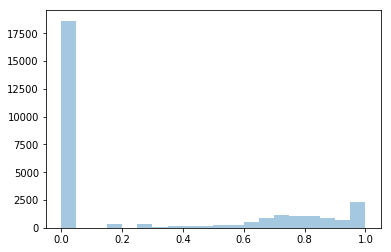

In [30]:
sns.distplot(values, kde=False, bins=20)
print((sum(values > 0.8), sum(values == 1), values.shape))

In [ ]:
# sum(values >= 0.6)

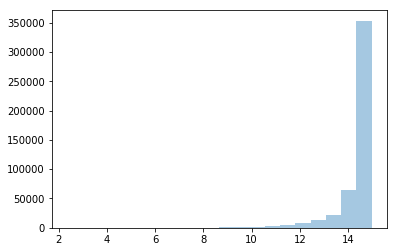

In [31]:
sns.distplot(vectorizer.idf_, kde=False, bins=20)

# Match results

In [ ]:
vectorizer.vocabulary_, len(vectorizer.vocabulary_)